# Assignment 2 - MC906: Approximating images with 50 circles using Genetic Algorithm

## Problem modeling:

### Individual: an image with 50 circles

Each circle (gene) has the following parameters:
* left(float): distance to the left normalized between [0.0, 1.0]
* top(float): distance to the top normalized between [0.0, 1.0]
* radius(float): Circle radius
* color(array-like(h,s,v)): Color to be used on render coded as HSV
* alpha(float): Opacity level bound to [0.0, 1.0]

### Population: several sets with 50 circles each


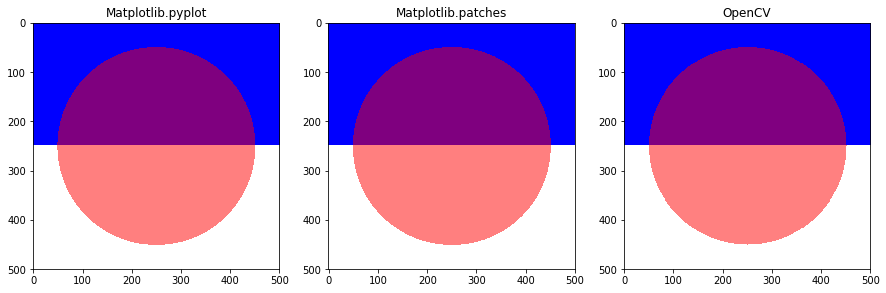

In [2]:
""" Circle plotting comparison """

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat

FILL_CIRCLE = -1

fig, axs = plt.subplots(ncols=3, figsize=(15,5))

images = np.full(shape=(3, 500,500, 3), dtype=np.uint8, fill_value=255)
images[:, :250, :, :2] = 0
xy = (250, 250)
radius = 200
alpha = 0.5
color = (255, 0, 0)
norm_color = tuple(c/255 if c > 1 else c for c in color)

# Matplotlib.pyplot
image, ax = images[0], axs[0]
ax.add_artist(plt.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.pyplot')

# Matplotlib.patches
image, ax = images[1], axs[1]
ax.add_patch(pat.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.patches')

# OpenCV
# https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#circle
image, ax = images[2], axs[2]
circle = np.copy(image)
cv2.circle(circle, center=xy, radius=radius, color=color, thickness=FILL_CIRCLE)
cv2.addWeighted(src1=circle, alpha=alpha, src2=image, beta=1-alpha, gamma=0, dst=image)
ax.imshow(image)
ax.set_title('OpenCV')

# fig.savefig('image', dpi=50)
plt.show()

## Useful links:

Aproximação por triangulos: https://github.com/DING-PENG/image-approx

## Indivíduos


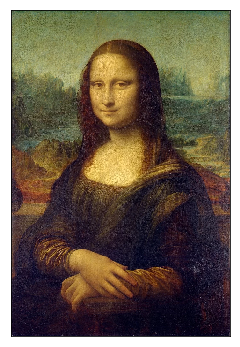

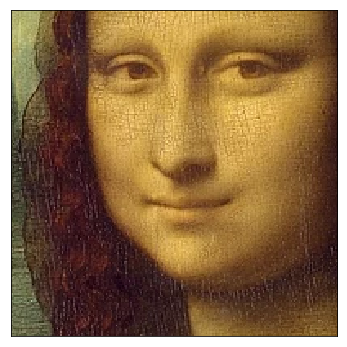

Gen: 0 Fitness: -0.183278990966579


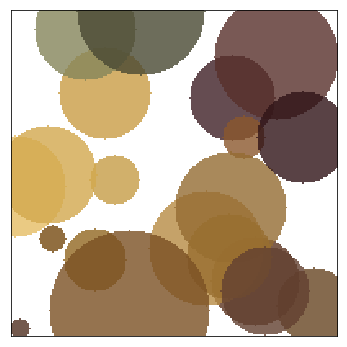

Mutating individuals: 9, 4, 1, 11, 9, 6, 11, 0, 6, 11
Gen: 1 Fitness: -0.18705266861934125
Mutating individuals: 11, 12, 3, 12, 18, 15, 11, 18, 12, 19
Gen: 2 Fitness: -0.19425407415795062
Mutating individuals: 7, 0, 19, 17, 1, 14, 8, 11, 10, 13
Gen: 3 Fitness: -0.19425407415795062
Mutating individuals: 7, 7, 11, 11, 14, 0, 11, 2, 6, 15
Gen: 4 Fitness: -0.2004595563181638
Mutating individuals: 3, 16, 19, 6, 7, 8, 4, 5, 4, 4
Gen: 5 Fitness: -0.2026194556717544
Mutating individuals: 5, 4, 0, 17, 4, 8, 6, 11, 10, 15
Gen: 6 Fitness: -0.2054585851001142
Mutating individuals: 7, 14, 18, 11, 7, 3, 17, 2, 8, 15
Gen: 7 Fitness: -0.20969446935271066
Mutating individuals: 9, 13, 13, 0, 14, 19, 11, 9, 18, 14
Gen: 8 Fitness: -0.20683421786945036
Mutating individuals: 14, 13, 14, 11, 1, 10, 1, 17, 18, 11
Gen: 9 Fitness: -0.21029387227785554
Mutating individuals: 8, 3, 4, 0, 18, 3, 5, 5, 17, 13
Gen: 10 Fitness: -0.21029387227785554


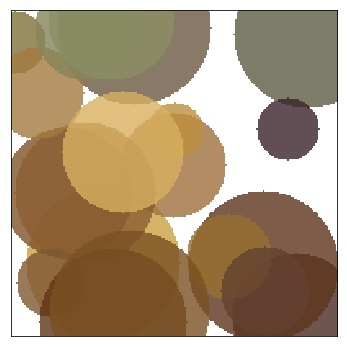

Mutating individuals: 1, 13, 18, 18, 3, 3, 2, 0, 4, 5
Gen: 11 Fitness: -0.21029387227785554
Mutating individuals: 8, 11, 13, 1, 12, 14, 9, 7, 7, 11
Gen: 12 Fitness: -0.21103421773399889
Mutating individuals: 12, 9, 4, 11, 11, 6, 2, 14, 7, 5
Gen: 13 Fitness: -0.21103421773399889
Mutating individuals: 5, 7, 14, 6, 14, 1, 1, 0, 12, 18
Gen: 14 Fitness: -0.21103421773399889
Mutating individuals: 2, 8, 13, 5, 18, 18, 6, 4, 17, 18
Gen: 15 Fitness: -0.21103421773399889
Mutating individuals: 6, 7, 19, 10, 10, 16, 11, 8, 0, 8
Gen: 16 Fitness: -0.21103421773399889
Mutating individuals: 5, 9, 12, 17, 15, 9, 17, 16, 4, 3
Gen: 17 Fitness: -0.21103421773399889
Mutating individuals: 13, 14, 14, 16, 7, 12, 6, 15, 13, 9
Gen: 18 Fitness: -0.21103421773399889
Mutating individuals: 9, 11, 1, 9, 2, 4, 14, 11, 11, 19
Gen: 19 Fitness: -0.21103421773399889
Mutating individuals: 0, 14, 11, 19, 5, 17, 0, 1, 7, 16
Gen: 20 Fitness: -0.21103421773399889


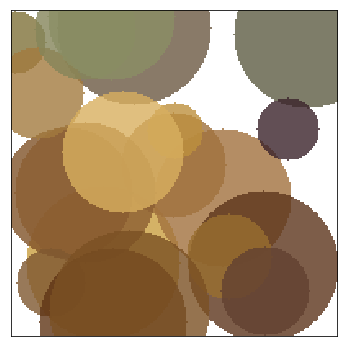

Mutating individuals: 0, 14, 18, 8, 13, 3, 12, 14, 9, 12
Gen: 21 Fitness: -0.21103421773399889
Mutating individuals: 10, 7, 10, 10, 4, 11, 18, 8, 11, 16
Gen: 22 Fitness: -0.21103421773399889
Mutating individuals: 11, 1, 16, 0, 17, 9, 9, 4, 10, 2
Gen: 23 Fitness: -0.21103421773399889
Mutating individuals: 15, 8, 10, 11, 0, 10, 9, 1, 3, 18
Gen: 24 Fitness: -0.21103421773399889
Mutating individuals: 5, 19, 13, 13, 1, 1, 5, 3, 16, 5
Gen: 25 Fitness: -0.21103421773399889
Mutating individuals: 2, 14, 8, 1, 16, 10, 12, 8, 11, 15
Gen: 26 Fitness: -0.21103421773399889
Mutating individuals: 7, 11, 5, 8, 14, 12, 13, 18, 19, 17
Gen: 27 Fitness: -0.21103421773399889
Mutating individuals: 9, 2, 10, 15, 3, 3, 2, 10, 5, 2
Gen: 28 Fitness: -0.21103421773399889
Mutating individuals: 12, 7, 12, 12, 12, 15, 11, 0, 6, 16
Gen: 29 Fitness: -0.21103421773399889
Mutating individuals: 0, 7, 8, 18, 9, 6, 1, 0, 5, 16
Gen: 30 Fitness: -0.21103421773399889


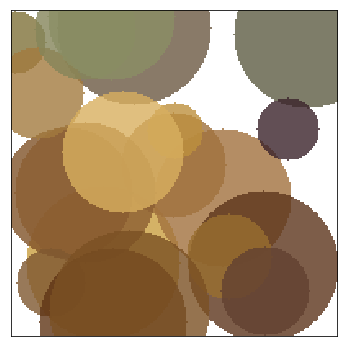

Mutating individuals: 12, 4, 1, 9, 8, 8, 7, 10, 4, 12
Gen: 31 Fitness: -0.21103421773399889
Mutating individuals: 6, 9, 8, 18, 11, 5, 3, 15, 9, 8
Gen: 32 Fitness: -0.21103421773399889
Mutating individuals: 11, 3, 9, 5, 19, 16, 11, 11, 18, 6
Gen: 33 Fitness: -0.21103421773399889
Mutating individuals: 14, 7, 4, 5, 10, 16, 5, 5, 17, 1
Gen: 34 Fitness: -0.21103421773399889
Mutating individuals: 4, 1, 13, 12, 3, 7, 19, 18, 0, 1
Gen: 35 Fitness: -0.21103421773399889
Mutating individuals: 7, 2, 4, 19, 12, 5, 7, 13, 12, 4


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

from circle import Circle
from image_from_circles import ImageFromCircles
from individual import Individual
from evolve import Evolve
from utils import rms, plot_image, save_image

from skimage.measure import compare_ssim

# plot_image(ImageFromCircles([Circle() for i in range(50)]).render((600, 800, 3)))

# Read reference image
image = cv2.imread('mona.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convert color loaded by OpenCV
plot_image(image)

# image_with_circle = np.copy(image)
# circle = Circle()
# circle.render(image_with_circle)
# plot_image(image_with_circle)
# print('rms:', rms(image, image_with_circle))
# print('ssim:', compare_ssim(image, image_with_circle, multichannel=True))

# ind = Individual(size=1, circles=[circle])
# print('fitness:', ind.update_fitness(image))
# print('ssim:', compare_ssim(image, ind.rendered, multichannel=True))
# plot_image(ind.rendered)

image = image[200:400, 200:400]
plot_image(image)

number_generations = 100

generation = Evolve(image, pop_size=20, crossover_rate=0.3, mutation_rate=0.5, individual_size=20)
generation.evaluate()
generation.plot_image()

for i in range(number_generations):
    generation.crossover()
    generation.mutate()
    generation.evaluate()
    if i % 10 == 9:
        generation.plot_image()